# Eksperimen Supply Chain Demand Forecasting
**Nama**: I Made Wisnu Adi Sanjaya  
**Proyek**: MLOps - Retail Demand Prediction

---

## 1. Perkenalan Dataset

### Informasi Umum
- **Nama Dataset**: Supply Chain Demand Forecasting
- **Sumber**: [Kaggle - Demand Forecasting](https://www.kaggle.com/datasets/aswathrao/demand-forecasting)
- **Tujuan**: Membangun model forecasting untuk memprediksi jumlah unit yang terjual (`units_sold`) guna mengoptimalkan manajemen stok dan supply chain

### Deskripsi
Dataset ini berisi riwayat transaksi penjualan selama **2-3 tahun** untuk berbagai produk (SKU) di **10 toko** berbeda. Data mencakup informasi temporal, lokasi, dan pricing yang dapat digunakan untuk memprediksi permintaan produk.

### Atribut Dataset
| Kolom | Tipe | Deskripsi |
|-------|------|----------|
| `week` | Date | Tanggal/minggu penjualan |
| `store_id` | Categorical | ID unik toko |
| `sku_id` | Categorical | ID produk (Stock Keeping Unit) |
| `base_price` | Numeric | Harga dasar produk |
| `total_price` | Numeric | Harga akhir setelah promosi/diskon |
| `units_sold` | Numeric | **Target**: Jumlah unit terjual (yang ingin diprediksi) |



## 2. Import Library

Mengimpor library yang dibutuhkan untuk pemrosesan data, visualisasi, dan pemodelan.


In [3]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import MEstimateEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Import config
try:
    from config import SKU_SPECIFIC_LAGS, SKU_SPECIFIC_MAS
    print("Config loaded successfully")
except ImportError:
    print("Config.py not found, using default values")
    SKU_SPECIFIC_LAGS = {216418: [1, 2, 3]}
    SKU_SPECIFIC_MAS = {216418: [2, 4]}

print(f"Target SKU: {list(SKU_SPECIFIC_LAGS.keys())}")
print(f"Lag features: {SKU_SPECIFIC_LAGS}")
print(f"Moving average windows: {SKU_SPECIFIC_MAS}")

Config loaded successfully
Target SKU: [216418, 216419]
Lag features: {216418: [1, 2, 5, 19], 216419: [1, 2, 5, 19]}
Moving average windows: {216418: [1, 2, 4], 216419: [1, 2, 4]}


## 3. Memuat Dataset

Memuat data training dari file CSV ke dalam pandas DataFrame.

In [4]:
# Load dataset
try:
    train = pd.read_csv('../data/train.csv')
    print("Dataset loaded successfully from ../data/train.csv")
except FileNotFoundError:
    if os.path.exists('data/train.csv'):
        train = pd.read_csv('data/train.csv')
        print("Dataset loaded successfully from data/train.csv")
    else:
        raise FileNotFoundError("train.csv not found in expected locations")

print(f"Dataset Shape: {train.shape}")
print(f"Total Records: {len(train):,}")
print(f"Total Features: {train.shape[1]}")

Dataset loaded successfully from ../data/train.csv
Dataset Shape: (150150, 9)
Total Records: 150,150
Total Features: 9


### Preview Data
Melihat sampel data untuk memahami struktur dataset.

In [5]:
# Tampilkan 10 baris pertama
train.head(10)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52
5,9,17/01/11,8091,219009,227.2875,227.2875,0,0,18
6,10,17/01/11,8091,219029,327.0375,327.0375,0,0,47
7,13,17/01/11,8091,223245,210.9000,210.9000,0,0,50
8,14,17/01/11,8091,223153,190.2375,234.4125,1,1,82
9,17,17/01/11,8095,216418,99.0375,99.0375,0,0,99


## 4. Exploratory Data Analysis (EDA)

Melakukan analisis terhadap dataset untuk memahami struktur, tipe data, missing values, dan distribusi statistik.

### 4.1 Informasi Dasar Dataset

In [6]:
# Dataset info
print("DATASET INFORMATION")
print("-" * 30)
print(train.info())

print("\nCOLUMN DATA TYPES")
print("-" * 30)
print(train.dtypes)

DATASET INFORMATION
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB
None

COLUMN DATA TYPES
------------------------------
record_ID            int64
week                object
store_id             int64
sku_id               int64
total_price        float64
base_price         float64
is_featured_sku      int64
is_display_sku 

### 4.2 Statistik Deskriptif

In [7]:
# Statistik deskriptif
print("DESCRIPTIVE STATISTICS")
print("-" * 30)
display(train.describe().T)

# Statistik untuk categorical features
print("\nCATEGORICAL FEATURES SUMMARY")
print("-" * 30)
print(f"Unique Stores: {train['store_id'].nunique()}")
print(f"Unique SKUs: {train['sku_id'].nunique()}")
print(f"Date Range: {train['week'].min()} to {train['week'].max()}")

DESCRIPTIVE STATISTICS
------------------------------


,count,mean,std,min,25%,50%,75%,max
record_ID,150150.0,106271.555504,61386.037861,1.000,53111.2500,106226.5000,159452.7500,212644.0000
store_id,150150.0,9199.422511,615.591445,8023.000,8562.0000,9371.0000,9731.0000,9984.0000
sku_id,150150.0,254761.132468,85547.306447,216233.000,217217.0000,222087.0000,245338.0000,679023.0000
total_price,150149.0,206.626751,103.308516,41.325,130.3875,198.0750,233.7000,562.1625
base_price,150150.0,219.425927,110.961712,61.275,133.2375,205.9125,234.4125,562.1625
is_featured_sku,150150.0,0.095611,0.294058,0.000,0.0000,0.0000,0.0000,1.0000
is_display_sku,150150.0,0.133200,0.339792,0.000,0.0000,0.0000,0.0000,1.0000
units_sold,150150.0,51.674206,60.207904,1.000,20.0000,35.0000,62.0000,2876.0000



CATEGORICAL FEATURES SUMMARY
------------------------------
Unique Stores: 76
Unique SKUs: 28
Date Range: 01/01/13 to 31/10/11


### 4.3 Pengecekan Kualitas Data

In [8]:
# Missing values analysis
print("MISSING VALUES ANALYSIS")
print("-" * 30)
missing = train.isnull().sum()
missing_pct = (missing / len(train) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage (%)': missing_pct
})
display(missing_df[missing_df['Missing Count'] > 0])

# Duplicates check
duplicates = train.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates} ({duplicates/len(train)*100:.2f}%)")

# Zero values in target
zero_units = (train['units_sold'] == 0).sum()
print(f"Zero Units Sold: {zero_units} ({zero_units/len(train)*100:.2f}%)")

MISSING VALUES ANALYSIS
------------------------------


,Missing Count,Percentage (%)
total_price,1,0.0



Duplicate Rows: 0 (0.00%)
Zero Units Sold: 0 (0.00%)


### 4.4 Visualisasi Distribusi Data

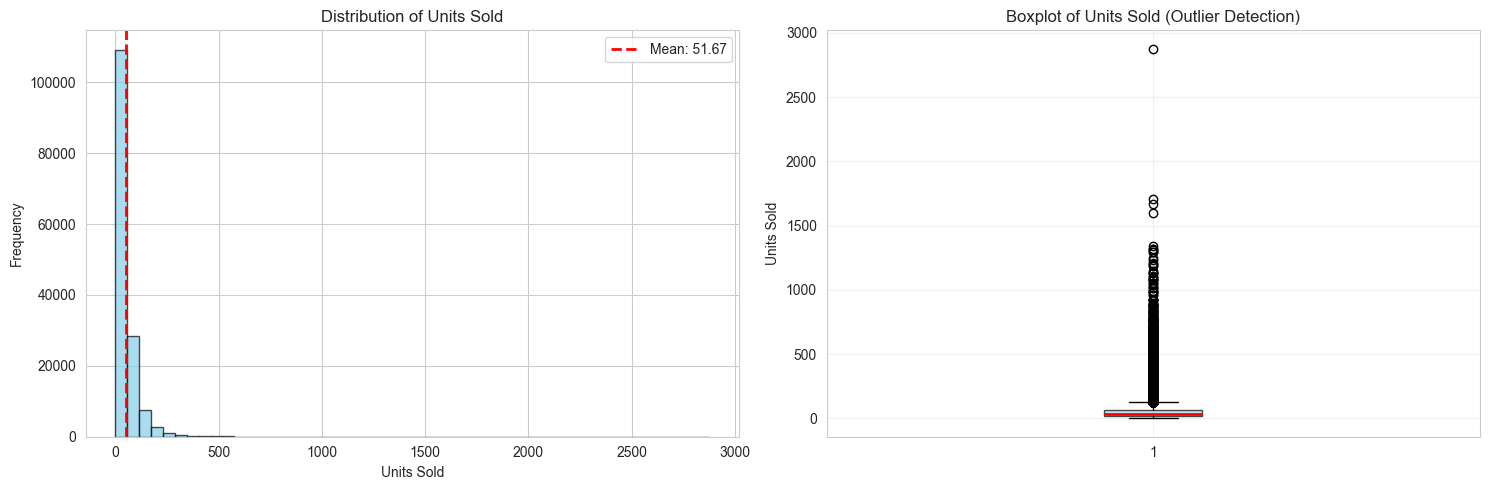

Mean Units Sold: 51.67
Median Units Sold: 35.00
Std Dev: 60.21


In [9]:
# Distribution of target variable
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(train['units_sold'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Units Sold')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Units Sold')
axes[0].axvline(train['units_sold'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train["units_sold"].mean():.2f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(train['units_sold'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Units Sold')
axes[1].set_title('Boxplot of Units Sold (Outlier Detection)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean Units Sold: {train['units_sold'].mean():.2f}")
print(f"Median Units Sold: {train['units_sold'].median():.2f}")
print(f"Std Dev: {train['units_sold'].std():.2f}")

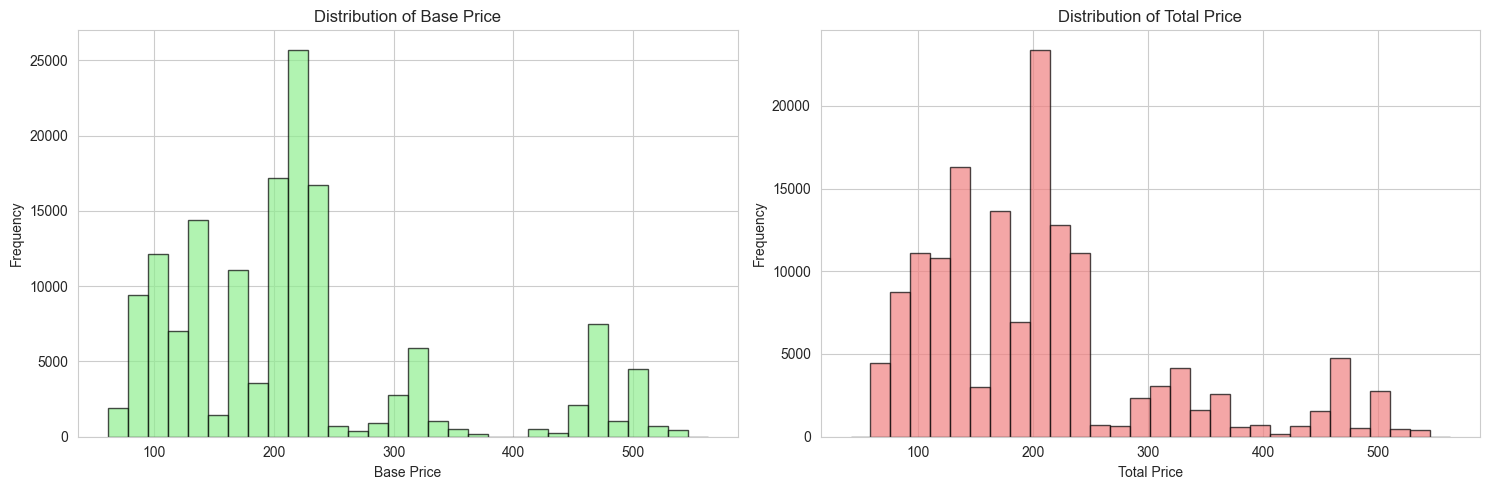

In [10]:
# Price distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Base price
axes[0].hist(train['base_price'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0].set_xlabel('Base Price')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Base Price')

# Total price
axes[1].hist(train['total_price'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].set_xlabel('Total Price')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Total Price')

plt.tight_layout()
plt.show()

### 4.5 Analisis Categorical Features

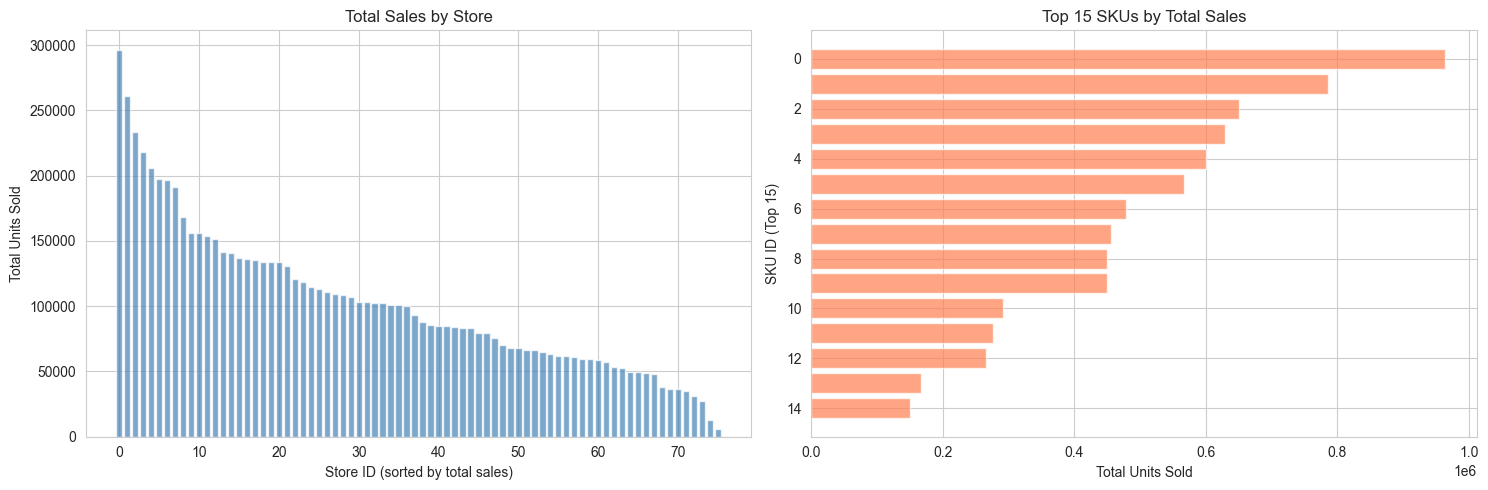


Top 3 Stores by Sales:
store_id
8023    296478
9845    261410
9823    233846
Name: units_sold, dtype: int64

Top 3 SKUs by Sales:
sku_id
219009    964194
216418    786087
223245    650165
Name: units_sold, dtype: int64


In [11]:
# Distribution by store and SKU
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Sales by store
store_sales = train.groupby('store_id')['units_sold'].sum().sort_values(ascending=False)
axes[0].bar(range(len(store_sales)), store_sales.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Store ID (sorted by total sales)')
axes[0].set_ylabel('Total Units Sold')
axes[0].set_title('Total Sales by Store')

# Top 15 SKUs by sales
sku_sales = train.groupby('sku_id')['units_sold'].sum().sort_values(ascending=False).head(15)
axes[1].barh(range(len(sku_sales)), sku_sales.values, color='coral', alpha=0.7)
axes[1].set_xlabel('Total Units Sold')
axes[1].set_ylabel('SKU ID (Top 15)')
axes[1].set_title('Top 15 SKUs by Total Sales')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nTop 3 Stores by Sales:")
print(store_sales.head(3))
print(f"\nTop 3 SKUs by Sales:")
print(sku_sales.head(3))

## 5. Data Preprocessing

Tahapan pembersihan dan transformasi data:
1. **Konversi Tipe Data**: Date parsing dan type conversion
2. **Handling Missing Values**: Imputasi nilai yang hilang
3. **Handling Duplicates**: Menghapus data duplikat
4. **Encoding**: Target encoding untuk categorical features
5. **Feature Engineering**: Membuat lag features dan moving averages untuk time series


### 5.1 Konversi Date & Fix Leap Year
Menangani masalah pencatatan tanggal (leap year).

In [12]:
print("Step 1: Date Conversion & Leap Year Fix")

# Convert to datetime
train['week'] = pd.to_datetime(train['week'], format='%d/%m/%y')

# Fix leap year issue (29 Feb 2012 -> 28 Feb 2012)
train.loc[train['week'] >= '2012-03-06', 'week'] -= pd.Timedelta(days=1)

print("Date converted successfully")
print(f"Date Range: {train['week'].min()} to {train['week'].max()}")
print(f"Total Days Covered: {(train['week'].max() - train['week'].min()).days}")

Step 1: Date Conversion & Leap Year Fix
Date converted successfully
Date Range: 2011-01-17 00:00:00 to 2013-07-08 00:00:00
Total Days Covered: 903


### 5.2 Handling Missing Values
Mengisi missing values pada `total_price` dengan `base_price`.

In [13]:
print("Step 2: Handling Missing Values")

missing_before = train['total_price'].isnull().sum()
train['total_price'] = train['total_price'].fillna(train['base_price'])
missing_after = train['total_price'].isnull().sum()

print(f"Missing values in total_price filled")
print(f"Before: {missing_before}")
print(f"After: {missing_after}")

Step 2: Handling Missing Values
Missing values in total_price filled
Before: 1
After: 0


### 5.3 Handling Duplicates

In [14]:
print("Step 3: Handling Duplicates")

initial_rows = len(train)
train = train.drop_duplicates()
final_rows = len(train)

print(f"Duplicates removed")
print(f"Initial rows: {initial_rows:,}")
print(f"Final rows: {final_rows:,}")

Step 3: Handling Duplicates
Duplicates removed
Initial rows: 150,150
Final rows: 150,150


### 5.4 Target Encoding
Menggunakan M-Estimate Encoder untuk mengubah `store_id` menjadi numerical value.

In [15]:
print("Step 4: Target Encoding")

# Initialize encoder
encoder = MEstimateEncoder(cols=['store_id'])
encoder.fit(train[['store_id']], train['units_sold'])

# Save encoder for inference
os.makedirs('model_artifacts', exist_ok=True)
joblib.dump(encoder, 'model_artifacts/store_encoder.pkl')

# Transform
train['store_encoded'] = encoder.transform(train[['store_id']])

print(f"Target encoding completed")
print(f"Encoder saved to: model_artifacts/store_encoder.pkl")
print(f"\nSample encoded values:")
display(train[['store_id', 'store_encoded']].drop_duplicates().head(10))

Step 4: Target Encoding
Target encoding completed
Encoder saved to: model_artifacts/store_encoder.pkl

Sample encoded values:


,store_id,store_encoded
0,8091,32.822096
9,8095,81.729464
27,8094,41.824952
51,8063,34.721843
70,8023,108.579156
91,8058,52.747142
106,8222,84.391574
124,8121,35.496230
142,8218,29.236945
155,8317,51.531209


### 5.5 Feature Engineering: Time Series Features

Membuat features untuk time series forecasting:
- **Lag Features**: Nilai sales pada t-1, t-2, dst
- **Moving Averages**: Rata-rata bergerak untuk menangkap trend

Catatan: Filter data hanya untuk SKU tertentu sesuai konfigurasi eksperimen.

In [16]:
print("Step 5: Feature Engineering - Time Series Features")

# Filter target SKUs
target_skus = list(SKU_SPECIFIC_LAGS.keys())
print(f"Target SKUs: {target_skus}")

rows_before_filter = len(train)
train = train[train['sku_id'].isin(target_skus)].copy()
rows_after_filter = len(train)

print(f"\nFiltering completed:")
print(f"Before: {rows_before_filter:,} rows")
print(f"After: {rows_after_filter:,} rows")

Step 5: Feature Engineering - Time Series Features
Target SKUs: [216418, 216419]

Filtering completed:
Before: 150,150 rows
After: 17,550 rows


In [17]:
print("Creating lag features and moving averages...")

df_list = []

for sku_id in target_skus:
    df_sku = train[train['sku_id'] == sku_id].copy().sort_values('week')
    
    # Create lag features
    lags = SKU_SPECIFIC_LAGS.get(sku_id, [1])
    for lag in lags:
        df_sku[f'lag_{lag}'] = df_sku['units_sold'].shift(lag)
    
    # Create moving average features
    mas = SKU_SPECIFIC_MAS.get(sku_id, [1])
    for window in mas:
        df_sku[f'ma_{window}'] = df_sku['units_sold'].rolling(window=window).mean().shift(1)
    
    df_list.append(df_sku)

# Concatenate all SKUs
df_final = pd.concat(df_list, ignore_index=True)

# Remove rows with NaN (from lag/MA operations)
df_final = df_final.dropna()
print(f"Total rows after dropna: {len(df_final):,}")

print(f"\nFeature engineering completed")
print(f"Final dataset shape: {df_final.shape}")

Creating lag features and moving averages...
Total rows after dropna: 17,512

Feature engineering completed
Final dataset shape: (17512, 17)


### 5.6 Hasil Preprocessing
Menampilkan sampel data yang sudah diproses.

In [18]:
print("Final Processed Dataset Preview")
print("-" * 30)
display(df_final.head(10))

print(f"\nFeature Statistics:")
display(df_final.describe().T)

Final Processed Dataset Preview
------------------------------


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,store_encoded,lag_1,lag_2,lag_5,lag_19,ma_1,ma_2,ma_4
19,1592,2011-01-17,9961,216418,98.3250,99.0375,0,1,146,70.756976,14.0,45.0,113.0,20.0,14.0,29.5,59.50
20,1550,2011-01-17,9909,216418,99.0375,89.0625,0,1,99,66.389717,146.0,14.0,138.0,30.0,146.0,80.0,61.50
21,1532,2011-01-17,9890,216418,99.0375,99.0375,0,1,113,59.549778,99.0,146.0,41.0,109.0,99.0,122.5,76.00
22,1508,2011-01-17,9881,216418,98.3250,98.3250,0,1,142,65.763899,113.0,99.0,45.0,104.0,113.0,106.0,93.00
23,1486,2011-01-17,9880,216418,86.9250,86.9250,0,1,82,45.878055,142.0,113.0,14.0,64.0,142.0,127.5,125.00
24,913,2011-01-17,9436,216418,85.5000,85.5000,0,0,27,31.535345,82.0,142.0,146.0,15.0,82.0,112.0,109.00
25,1468,2011-01-17,9879,216418,87.6375,86.9250,0,1,61,37.769811,27.0,82.0,99.0,24.0,27.0,54.5,91.00
26,1426,2011-01-17,9872,216418,84.0750,84.0750,0,0,113,54.553508,61.0,27.0,113.0,65.0,61.0,44.0,78.00
27,1400,2011-01-17,9845,216418,98.3250,106.1625,0,1,239,118.254941,113.0,61.0,142.0,88.0,113.0,87.0,70.75
28,1380,2011-01-17,9809,216418,98.3250,98.3250,0,0,89,60.820032,239.0,113.0,82.0,228.0,239.0,176.0,110.00



Feature Statistics:


,count,mean,min,25%,50%,75%,max,std
record_ID,17512.0,106519.562414,17.0,53475.75,106498.5,159605.25,212623.0,61257.809982
week,17512,2012-04-13 11:30:48.515303680,2011-01-17 00:00:00,2011-08-29 00:00:00,2012-04-16 00:00:00,2012-11-26 00:00:00,2013-07-08 00:00:00,NaN
store_id,17512.0,9241.737323,8023.0,8911.0,9432.0,9731.0,9984.0,596.29789
sku_id,17512.0,216418.496288,216418.0,216418.0,216418.0,216419.0,216419.0,0.5
total_price,17512.0,92.165244,61.275,85.5,88.35,106.1625,130.3875,14.201531
base_price,17512.0,94.800298,61.275,86.2125,89.0625,106.1625,130.3875,12.734951
is_featured_sku,17512.0,0.038145,0.0,0.0,0.0,0.0,1.0,0.191552
is_display_sku,17512.0,0.299852,0.0,0.0,0.0,1.0,1.0,0.458206
units_sold,17512.0,80.599589,1.0,37.75,63.0,105.0,1099.0,63.529564
store_encoded,17512.0,51.392685,20.285214,35.466598,44.205858,61.173669,118.254941,20.052508


## 6. Simpan Hasil

Menyimpan data yang sudah diproses ke format CSV.

In [19]:
# Create output directory
os.makedirs('data/processed', exist_ok=True)
output_path = 'data/processed/train_processed.csv'

# Save to CSV
df_final.to_csv(output_path, index=False)

print("DATA PREPROCESSING COMPLETED")
print("-" * 30)
print(f"Processed data saved to: {output_path}")
print(f"\nFinal Statistics:")
print(f"  - Total Records: {len(df_final):,}")
print(f"  - Total Features: {df_final.shape[1]}")

DATA PREPROCESSING COMPLETED
------------------------------
Processed data saved to: data/processed/train_processed.csv

Final Statistics:
  - Total Records: 17,512
  - Total Features: 17
